# Thesis thoughts and tests, week 1

This is a summary of my work to date. The first cell contains all the helper functions and such, and can be safely skipped.

In [1]:
import skimage.io
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
from IPython.display import Image

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import seaborn as sns


%matplotlib inline

## Cairo stuff - offload to somewhere else

# Get a point as a pixel location
def point_to_pixel(x, y, w, h):
    xp = int(min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds
    yp = int(min(h-1, (y*(h/2) + h/2)))
    return xp, yp

# Floating point version (for interpolation methods later)
def point_to_pixelf(x, y, w, h):
    xp = (min(w-1, (x*(w/2) + w/2))) # Avoid going out of bounds - a little less accurate but hey
    yp = (min(h-1, (y*(h/2) + h/2)))
    return xp, yp

# Make a point on a unit cirle given an angle
def point_on_circle(angle):
    x, y = math.cos(angle), math.sin(angle)
    return x, y

# Drae a set of emitters and detectors
def draw_des(ds, es, width, height):

    ## Cairo STUFF

    width, height = 600, 600

    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context (surface)

    ctx.set_source_rgb(1,1,1)
    ctx.rectangle(0,0,width,height)
    ctx.fill()

    def circle(ctx, x, y, size):
        ctx.arc(x, y, size, 0, 2 * math.pi)

    ## Back to the good stuff

    # Connect detectors to emitters
    ctx.set_line_width(2)
    ctx.set_source_rgb(0, 0.5, 0)
    for e in es:
        for d in ds:
            ctx.move_to(*point_to_pixel(e[0], e[1], width, height)) # Wow that's a nifty trick!!
            ctx.line_to(*point_to_pixel(d[0], d[1], width, height))
    ctx.stroke()

    # Draw detectors
    ctx.set_source_rgb(0, 0, 1)
    for d in ds:
        cx, cy = point_to_pixel(d[0], d[1], width, height)
        circle(ctx, cx, cy, 20)
        ctx.fill()
        ctx.stroke()

    # Draw Emitters
    ctx.set_source_rgb(1, 0, 1)
    for e in es:
        cx, cy = point_to_pixel(e[0], e[1], width, height)
        circle(ctx, cx, cy, 10)
        ctx.fill()
        ctx.stroke()
        
    return surface

def random_test_image(w, h, r, max_displacement):
    # A random circle within the unit circle
    x, y = 1, 1
    while (x**2 + y**2 > max_displacement**2): # Some margin to avoid overlapping the circles circumference
        x, y = random.random(), random.random() # Shouldn't take too long
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
    xp -= r
    yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def test_image(w, h, r, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
    xp -= r
    yp -= r # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, r, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(w, h, 4)[:,:,0]
    return surface, img, x, y

def get_paths(img, ds, es, width, height):
    # Does interpolation along all paths from emitters to detectors, given an image, detectors and emitters
    lines = []
    for e in es:
        for d in ds:
            x0, y0 = point_to_pixelf(*e, width, height)
            x1, y1 = point_to_pixelf(*d, width, height)

            # Make samplng points
            length = int(np.hypot(x1-x0, y1-y0))
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            # Extract the values along the line
            zi = img[x.astype(np.int), y.astype(np.int)]
            lines.append(sum(zi))
    return lines

def get_random_des(nd, ne):
    ds, es = [], []
    for i in range(nd):
        ds.append(point_on_circle((2*i/nd+(random.random()-0.5)*0.3)*3.14159265))
    for i in range(ne):
        es.append(point_on_circle((2*i/ne+(random.random()-0.5)*0.3)*3.14159265))
    return ds, es

def interp(start, end, width, height, img):
    x0, y0 = point_to_pixelf(*start, width, height)
    x1, y1 = point_to_pixelf(*end, width, height)

    # Make samplng points
    length = int(np.hypot(x1-x0, y1-y0))
    x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

    # Extract the values along the line
    zi = img[x.astype(np.int), y.astype(np.int)]
    return sum(zi), zi

def e_vs_t_pos():
    X, y, Xt, yt = [], [], [], []

    # 100 tests
    for i in range(100):
        s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
        paths = get_paths(img, ds, es, 256, 256)
        Xt.append(paths)
        yt.append([xi,yi])

    # 1000 training samples
    for i in range(1024):
        s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
        paths = get_paths(img, ds, es, 256, 256)
        X.append(paths)
        y.append([xi,yi])

    # Instantiate the model
    from sklearn.preprocessing import StandardScaler
    from sklearn.neural_network import MLPRegressor

    # Scale the inputs (important)
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    Xt = scaler.transform(Xt)

    # for i in range(11): # 2^10 = 1024
    #     n = 2**i
    #     print(n)
    #     mlp = MLPRegressor(hidden_layer_sizes=(20,20,20))


    #     # Train the neural network
    #     mlp.fit(X[:n], y[:n])

    #     # Predict the positions of the test images from the test inputs
    #     predictions = mlp.predict(Xt)
    #     e = predictions.clip(0, 1)-yt
    #     errors = [(d[0]**2 + d[1]**2)**0.5 for d in e ]
    #     print(sum(errors))

    ses = []
    ns = range(10, 1000, 20)
    for n in ns: # 2^10 = 1024
        mlp = MLPRegressor(hidden_layer_sizes=(20,20,20))
        # Train the neural network
        mlp.fit(X[:n], y[:n])
        # Predict the positions of the test images from the test inputs
        predictions = mlp.predict(Xt)
        e = predictions.clip(0, 1)-yt
        errors = [(d[0]**2 + d[1]**2)**0.5 for d in e ]
        ses.append(sum(errors))
    plt.plot(ns, ses, label='Error vs N training samples')


## Step 1 - Defining the sensor layout

We specify the locations of sensors and detectors. I've been specifying them in a coordinate system that goes from -1 to 1 on both axes, and usually place them on the unit circle. Here, I make 8 emitters and 9 detectors and arrange them semi-randomly.

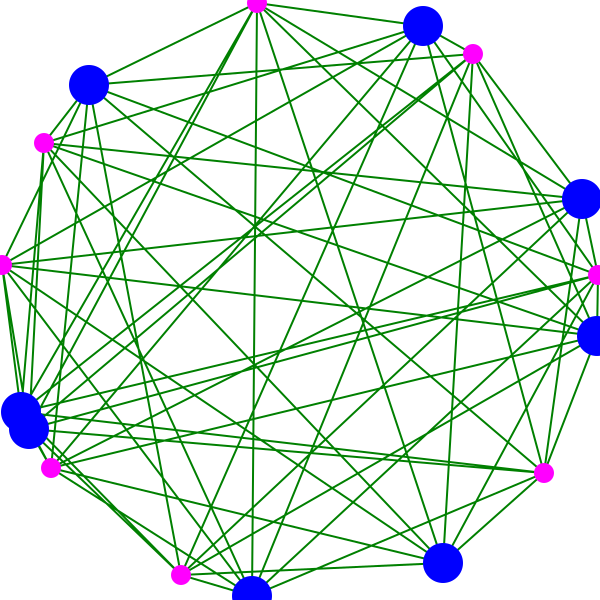

In [2]:
# GENERATE EMITTERS AND DETECTORS in ds and es (coordinate space from -1 to 1 x and y)
ds, es = get_random_des(8, 8) # Each one is a (x,y) pair

# Show them:
s = draw_des(ds, es, 500, 500)
s.write_to_png('t4.png')
Image('t4.png')

## Step 2 - Representing an object being scanned

We represent an object as a greyscale image. The intensity reflects how much light the material lets through. Since this is all hypothetical at the moment, I make some simplifying assumptions. For the tests in this notebook, I've been generating small (256x256) images with a circle somewhere in the unit circle. For example, to make one in the center:

Circle location: 0.5 0.5


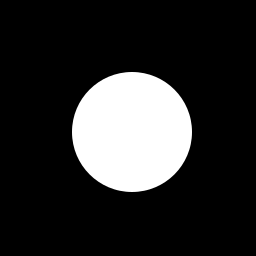

In [3]:
s, img, x, y = test_image(256, 256, 60, 0.5, 0.5) # Central 
# s, img, x, y = random_test_image(256, 256, 60, 0.8) # w, h, radius of circle, max dist from center
print("Circle location:",x, y)
s.write_to_png('t1.png')
Image('t1.png')

## Step 3 - Tracing along a path

To see how much light will get from an emitter to a detector, we sum the pixel values along a path in the image from the emitter location to the detector location.

The sum along the line:  30354
Plotting the values along the line:


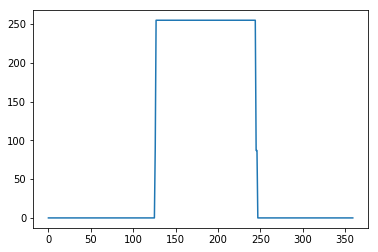

In [4]:
s, values = interp((-1, -1), (1, 1), 256, 256, img)
print("The sum along the line: ", s)
print("Plotting the values along the line:")
plt.plot(values)

## Step 4 - Tracing along all paths from emitters to detectors

This represents the scan in full. We can optionally rotate all the emitters, detectors or both to get more readings.

For example, for the semi-random arrangement shown in step 1, with 8 es and 8 ds:

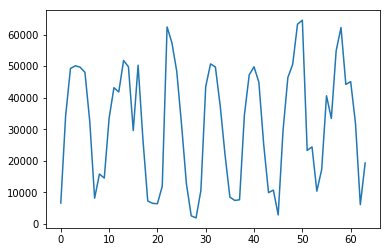

In [5]:
lines = get_paths(img, ds, es, 256, 256)
plt.plot(lines) # 64 values (nd*ne) as expected.

## Step 5 - Going from these readings back to an image

TODO: backprojection

We need some way to get back to the object being scanned. Most of the work to date has been done on well defined, regular arrangements of sensors and many readings (For example filtered backprojection). Here, I decided to try out neural networks and see if I could train a network to reconstruct an image from the readings. 

### 5.1 - Infering position

I decided to start with a fairly simple task - getting the position of the test circle from the sensor readings. We generate some training data and some test data, and try to predict the positions of the circles in the test data based on the readings returned by get_paths(). As you can see, the model does fairly well, getting the position within ~10% (1 sd) with only 100 training images.

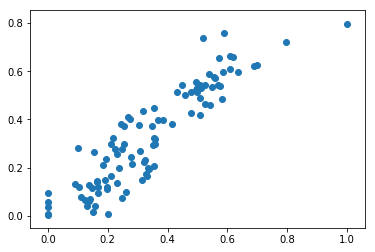

In [8]:
# Generating training data:

X_train = []
Y_train = []
X_test = []
Y_test = []

for i in range(100):
    s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
    paths = get_paths(img, ds, es, 256, 256)
    X_train.append(paths) # The simulated readings
    Y_train.append([xi,yi]) # The position
    
for i in range(100):
    s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
    paths = get_paths(img, ds, es, 256, 256)
    X_test.append(paths) # The simulated readings
    Y_test.append([xi,yi]) # The position
    
# Scale the inputs (NNs sensitive to input scaling) - without this we get far worse performance
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    
# Creating and training the neural network
mlp = MLPRegressor(hidden_layer_sizes=(20,20,20))
mlp.fit(X_train, Y_train)

# Predicting the positions for the test data
predictions = mlp.predict(X_test)

# Plot predicted X values vs actual:
plt.scatter(predictions[:,0].clip(0,1), np.asarray(Y_test)[:,0]) # A couple of outliers sometimes

Standard deviation of errors: 0.08302110336615294


/home/jonathan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


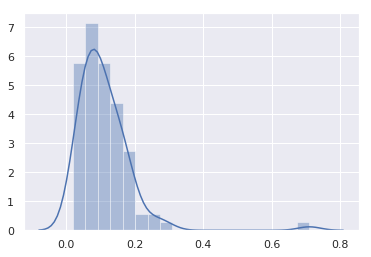

In [9]:
# View the distribution of the errors
e = predictions.clip(0, 1)-Y_test
errors = [(d[0]**2 + d[1]**2)**0.5 for d in e ]
print("Standard deviation of errors:",np.asarray(errors).std())
sns.set(color_codes=True)
sns.distplot(errors);

Let's see how the errors change with more training data

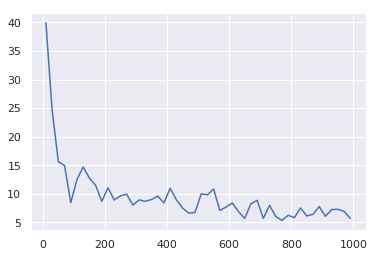

In [10]:
e_vs_t_pos() # Plots the total error vs the number of training images.

It converges to ~10% error fairly quicky. This makes sense to me in light of the fact that the effective resolution is going to be governed by the 'effective sensor radius', which for 16 es or ds is ~0.1 (do maths and find ref)

### 5.2 - Image inference

Now the fun part - going back to the actual images from the scans. This shouldn't be possible, but the fact that we know we can always expect a circle radius 60 helps. This is an example where for a specialized use case we can get good returns by knowing what to expect and doing adequate simulation.

In [11]:
X, y, Xt, yt = [], [], [], []

def downsample(img):
    out = []
    for r in range(len(img)):
        if r%16 == 0:
            #row = []
            for c in range(len(img[r])):
                if c%16 == 0:
                    out.append(img[r][c])
            #out.append(row)
    return np.asarray(out)

# 100 tests
for i in range(100):
    s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
    paths = get_paths(img, ds, es, 256, 256)
    Xt.append(paths)
    yt.append(downsample(img))
    
# 100 training samples
for i in range(1000):
    s, img, xi, yi = random_test_image(256, 256, 60, 0.8)
    paths = get_paths(img, ds, es, 256, 256)
    X.append(paths)
    y.append(downsample(img))
    
# Instantiate the model
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Scale the inputs (important)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
Xt = scaler.transform(Xt)

mlp = MLPRegressor(hidden_layer_sizes=(20,20,20))
mlp.fit(X, y)

/home/jonathan/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

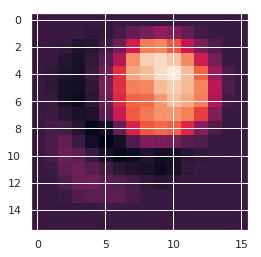

In [12]:
plt.imshow(mlp.predict(Xt)[0].reshape(16, 16))

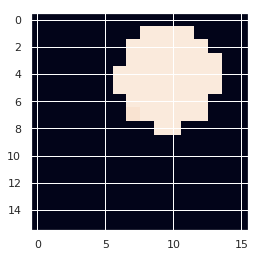

In [13]:
plt.imshow(yt[0].reshape(16, 16))

In [14]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def test_image(w, h, x, y):
    surface = cairo.ImageSurface (cairo.FORMAT_ARGB32, w, h)
    ctx = cairo.Context (surface)
    ctx.set_source_rgb(0, 0, 0)
    ctx.rectangle(0,0,w,h)
    ctx.fill()
    xp, yp = point_to_pixel(x, y, w, h)
    xp -= 60
    yp -= 60 # Subtract the radius
    ctx.set_source_rgb(1, 1, 1)
    ctx.arc(xp, yp, 60, 0, 2 * math.pi)
    ctx.fill()
    ctx.stroke()
    buf  = np.frombuffer(surface.get_data(), np.uint8)
    img = buf.reshape(256, 256, 4)[:,:,0]
    return surface, img, x, y


def f(x, y):
    s, img, a, b = test_image(256, 256, x, y)
    d = downsample(img)
    paths = get_paths(img, ds, es, 256, 256)
    pred = mlp.predict(np.asarray(paths).reshape(1, -1))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(paths)
    ax2 = plt.subplot(2, 2, 3)
    ax2.imshow(img)#d.reshape(16, 16))
    ax3 = plt.subplot(2, 2, 4)
    ax3.imshow(pred.reshape(16, 16))

interactive_plot = interactive(f, x=0.5, y=0.5)
output = interactive_plot.children[-1]
output.layout.height = '400px'


interactive_plot

interactive(children=(FloatSlider(value=0.5, description='x', max=1.5, min=-0.5), FloatSlider(value=0.5, descr…